# Home Credit Scorecard Model
Project by Muhammad Farras Rizki

### Latar Belakang
Dataframe yang digunakan milik Home Credit Indonesia. Manajemen Home Credit Indonesia ingin membuat membuat prediksi skor kredit. Dengan tujuan, dapat memastikan pelanggan yang mampu melakukan pelunasan tidak ditolak ketika melakukan pengajuan pinjaman, dan pinjaman datap diberikan dengan principal, maturity, dan repayment calendar yang akan memotivsi pelanggan untuk sukses.


### Tentang Dataframe
Dataframe `application_train` berisikan 307511 baris yang merupakan ID transaksi peminjaman pelanggan yang telah terlaksana, baik yang berhasil maupun yang gagal. Data tersebut meliputi informasi demografis pelanggan (umur, pendapatan, dll), hubungan nasabah dengan bank (hipotek, rekening, surat berharga, dll), dan status akhir hasil pengajuan pinjaman nasabah (`TARGET`). Di antara 307511 nasabah ini, terdapat 24000 pelanggan (8%) yang mengalami gagal bayar.


### Tujuan Proyek
Membuat Model Machine Learning yang dapat memberikan sebuah score kelayakan pada client dalam memperoleh pinjaman.


### Sumber Dataset
Sumber: https://rakamin-lms.s3.ap-southeast-1.amazonaws.com/vix-assets/home-credit-indonesia/home-credit-default-risk.zip


### Deskripsi Singkat Pemodelan 
Tujuan dari pemodelan adalah ingin membuat model yang mampu memprediksi skor kredit seorang pelanggan, agar dapat memastikan pelanggan yang mampu melakukan pelunasan tidak ditolak ketika melakukan pengajuan pinjaman. Target Variabel yang akan digunakan adalah `TARGET` (status akhir hasil pengajuan pinjaman nasabah sebelumnya). Variabel yang paling diinginkan untuk optimal adalah F1-score karena ingin meminimalisir false positive maupun false negative.

Prediksi / Hipotesis yang dibuat berdasarkan target variabel :
- 0: Pelanggan mampu melakukan pelunasan (Positive)
- 1: Pelanggan tidak mampu melakukan pelunasan (Negative)
- False Positive: Diprediksi pelanggan mampu mampu melakukan pelunasan, Namun aktualnya pelanggan tidak mampu melakukan pelunasan
- False Negative: Diprediksi pelanggan tidak mampu melakukan pelunasan, Namun aktualnya pelanggan mampu melakukan pelunasan

Model Machine Learning yang akan diuji antara lain:
1. Logical Regression
2. K-NN
3. Naive Bayes
4. Decision Tree Classification

# Data Preparation

## 1. Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore')

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from tqdm import tqdm

from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from statsmodels.stats.outliers_influence import variance_inflation_factor as vif 
from statsmodels.tools.tools import add_constant



from scipy.stats import chi2_contingency
from sklearn.feature_selection import mutual_info_classif

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import (recall_score,
                            precision_score,
                            f1_score,
                            classification_report,
                            roc_auc_score)

from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ROCAUC

## 2. Import Data

In [2]:
application_train = pd.read_csv('home-credit-default-risk/application_train.csv')

## 3. Function Definition

### 3.1 Check Info Data

In [3]:
def info_data(data) :
    pd.set_option('display.max_rows',None)
    missing_values = data.isnull().sum()
    missing_perc = (missing_values/len(data))*100
    data_type = data.dtypes
    num_unique = data.nunique()
    
    print (f'Number of Rows,Columns {data.shape}')
    print (f'Number of Duplicated Values {data.duplicated().sum()}')
    
    return pd.DataFrame ({'Missing_value' : missing_values,
                          'Percent_missing_%' : missing_perc,
                          'Data_type' : data_type,
                          'Number of Unique' : num_unique}).sort_values('Percent_missing_%',ascending=False)

### 3.2 Check Outliers

In [4]:
def outlier(df,column) :
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3-q1
    lower = q1 - (1.5*iqr)
    upper = q3 + (1.5*iqr)
    
    outlier_list=df[column].apply(lambda x:'outlier' if x<lower or x>upper else 'not-outlier')
    print (f' outlier lower limit : {lower} \n outlier upper limit : {upper}')
    return outlier_list

### 3.3 Uji Statistik

In [5]:
def chi_cek (x,y) :
    
    obs_x = pd.crosstab(X_train[x],X_train[y])
    chi2, p, dof, expected = chi2_contingency(obs_x)
    alpha = 0.05

    
    if p<alpha :
        print (f'===== {x} =====')
        print('Number Expected :')
        print(expected)
        print()
        print (f'Chi-square Statistic : {chi2} ,p-value: {p} kurang dari {alpha} \nVariabel 1 dan Variabel 2 adalah variabel dependent')
        print()
        
    else : 
        print (f'===== {x} =====')
        print('Number Expected :')
        print(expected)
        print()
        print (f'Chi-square Statistic : {chi2} ,p-value: {p} lebih dari {alpha} \nVariabel 1 dan Variabel 2 adalah variabel independent')
        print()

In [6]:
def annova_cek (x) :
    churn_yes = X_train[X_train['Churn']==1][x]
    churn_no  = X_train[X_train['Churn']==0][x]

    alpha = 0.05
    ftest,p_value = f_oneway(churn_yes,churn_no)

    if p_value < alpha :
        print(x)
        print(f'Kesimpulan : nilai p_value {p_value} kurang dari alpha {alpha}, nilai ftest = {ftest}')
        print('Terdapat perbedaan target yang signifikan dari segi predictor')
        print()

    else :
        print(x)
        print(f'Kesimpulan : nilai p_value {p_value} lebih dari alpha {alpha}, nilai ftest = {ftest}')
        print('Tidak terdapat perbedaan target yang signifikan dari segi predictor')
        print()

### 3.4 Model Evaluation

In [7]:
def eval_train (X,y,model) :
    model.fit(X,y)
    prediction = model.predict(X)
    
    cm = confusion_matrix(y,prediction,labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                                  display_labels=model.classes_)
    
    print(f' Recall Score : {recall_score(y,prediction)}')
    print(f' Precision Score : {precision_score(y,prediction)}')
    print(f' F1 Score : {f1_score(y,prediction)}')
    print(f' ROC-AUC Score : {roc_auc_score(y,model.predict_proba(X)[:,1])}')
    
    disp.plot()

In [8]:
def eval_test (X,y,model) :
    prediction = model.predict(X)
    
    cm = confusion_matrix(y,prediction,labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                                  display_labels=model.classes_)
    
    print(f' Recall Score : {recall_score(y,prediction)}')
    print(f' Precision Score : {precision_score(y,prediction)}')
    print(f' F1 Score : {f1_score(y,prediction)}')
    print(f' ROC-AUC Score : {roc_auc_score(y,model.predict_proba(X)[:,1])}')
    
    disp.plot()

## 4. Data Inspection

In [9]:
application_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


### 4.1 Pilih Features

In [11]:
# Memilih fitur yang akan digunakan (Secara bussiness sense / tanpa riset)
df = application_train[['SK_ID_CURR',
'NAME_CONTRACT_TYPE',
'CODE_GENDER',
'FLAG_OWN_CAR',
'FLAG_OWN_REALTY',
'CNT_CHILDREN',
'AMT_INCOME_TOTAL',
'AMT_CREDIT',
'DAYS_BIRTH',
'CNT_FAM_MEMBERS',
'REGION_RATING_CLIENT',
'WEEKDAY_APPR_PROCESS_START',
'REG_REGION_NOT_LIVE_REGION',
'TARGET']]

In [115]:
df['TARGET'].value_counts()

0    282680
1     24825
Name: TARGET, dtype: int64

In [12]:
df.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,DAYS_BIRTH,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,WEEKDAY_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,TARGET
0,100002,Cash loans,M,N,Y,0,202500.0,406597.5,-9461,1.0,2,WEDNESDAY,0,1
1,100003,Cash loans,F,N,N,0,270000.0,1293502.5,-16765,2.0,1,MONDAY,0,0
2,100004,Revolving loans,M,Y,Y,0,67500.0,135000.0,-19046,1.0,2,MONDAY,0,0
3,100006,Cash loans,F,N,Y,0,135000.0,312682.5,-19005,2.0,2,WEDNESDAY,0,0
4,100007,Cash loans,M,N,Y,0,121500.0,513000.0,-19932,1.0,2,THURSDAY,0,0


In [13]:
info_data(df)

Number of Rows,Columns (307511, 14)
Number of Duplicated Values 0


,Missing_value,Percent_missing_%,Data_type,Number of Unique
CNT_FAM_MEMBERS,2,0.00065,float64,17
SK_ID_CURR,0,0.00000,int64,307511
NAME_CONTRACT_TYPE,0,0.00000,object,2
CODE_GENDER,0,0.00000,object,3
FLAG_OWN_CAR,0,0.00000,object,2
FLAG_OWN_REALTY,0,0.00000,object,2
CNT_CHILDREN,0,0.00000,int64,15
AMT_INCOME_TOTAL,0,0.00000,float64,2548
AMT_CREDIT,0,0.00000,float64,5603
DAYS_BIRTH,0,0.00000,int64,17460


In [14]:
# Cek unique values
for x in df.columns : 
    print (f'===== {x} =====')
    print (f'{df[x].unique()}')
    print()

===== SK_ID_CURR =====
[100002 100003 100004 ... 456253 456254 456255]

===== NAME_CONTRACT_TYPE =====
['Cash loans' 'Revolving loans']

===== CODE_GENDER =====
['M' 'F' 'XNA']

===== FLAG_OWN_CAR =====
['N' 'Y']

===== FLAG_OWN_REALTY =====
['Y' 'N']

===== CNT_CHILDREN =====
[ 0  1  2  3  4  7  5  6  8  9 11 12 10 19 14]

===== AMT_INCOME_TOTAL =====
[202500.  270000.   67500.  ...  96768.  546250.5 113062.5]

===== AMT_CREDIT =====
[ 406597.5 1293502.5  135000.  ...  181989.   743863.5 1391130. ]

===== DAYS_BIRTH =====
[ -9461 -16765 -19046 ...  -7951  -7857 -25061]

===== CNT_FAM_MEMBERS =====
[ 1.  2.  3.  4.  5.  6.  9.  7.  8. 10. 13. nan 14. 12. 20. 15. 16. 11.]

===== REGION_RATING_CLIENT =====
[2 1 3]

===== WEEKDAY_APPR_PROCESS_START =====
['WEDNESDAY' 'MONDAY' 'THURSDAY' 'SUNDAY' 'SATURDAY' 'FRIDAY' 'TUESDAY']

===== REG_REGION_NOT_LIVE_REGION =====
[0 1]

===== TARGET =====
[1 0]



Observasi:
- Dataframe `df` terdiri dari 307511 baris dan 14 kolom 
- 1 baris, dengan Unique ID `SK_ID_CURR` merepresentasikan ID setiap transaksi peminjaman kredit client
- Tidak terdapat duplicated rows
- Terdapat missing values pada kolom `CNT_FAM_MEMBERS` (<5%  == Drop)
- Pada Kolom `CODE_GENDER` terdapat unique values yang asing, yaitu 'XNA'
- Values pada kolom `DAYS_BIRTH ` adalah umur dalam jumlah hari (bertanda negatif)  

### 4.2 Data Cleansing

In [15]:
# Hapus kolom 'SK_ID_CURR' (Hanya digunakan untuk cek duplicated rows) 

df.drop(['SK_ID_CURR'], axis = 'columns', inplace = True)

In [16]:
# Handling Missing Values pada kolom `CNT_FAM_MEMBERS`

df = df[df['CNT_FAM_MEMBERS'].notna()].reset_index(drop=True)

In [17]:
# Hapus nilai 'XNA' pada kolom `CODE_GENDER`

df = df[~df['CODE_GENDER'].str.contains('XNA')]

In [18]:
# Merubah nilai pada kolom `DAYS_BIRTH` kedalam tahu

df['DAYS_BIRTH'] = df['DAYS_BIRTH'].abs()
df['DAYS_BIRTH'] = (df['DAYS_BIRTH'].div(365).round(0))

In [19]:
info_data(df)

Number of Rows,Columns (307505, 13)
Number of Duplicated Values 3215


,Missing_value,Percent_missing_%,Data_type,Number of Unique
NAME_CONTRACT_TYPE,0,0.0,object,2
CODE_GENDER,0,0.0,object,2
FLAG_OWN_CAR,0,0.0,object,2
FLAG_OWN_REALTY,0,0.0,object,2
CNT_CHILDREN,0,0.0,int64,15
AMT_INCOME_TOTAL,0,0.0,float64,2548
AMT_CREDIT,0,0.0,float64,5603
DAYS_BIRTH,0,0.0,float64,49
CNT_FAM_MEMBERS,0,0.0,float64,17
REGION_RATING_CLIENT,0,0.0,int64,3


# Exploratory Data Analysis

## 5. Spliting Data Train dan Test

In [104]:
# Cek perbandingan target
x = df['TARGET'].value_counts(normalize=True)

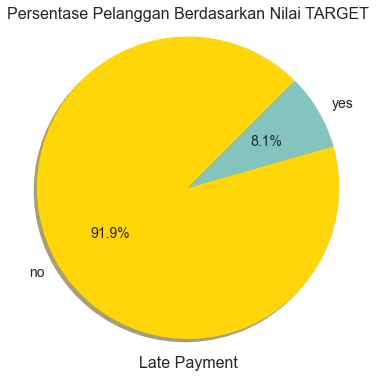

In [113]:
plt.figure(figsize=(6,6))

conversion_rate = x.index
count = x.values
colors= ['#ffd60a','#83c5be']

plt.pie(count, labels=['no','yes'],
        shadow=True,
        colors=colors, 
        autopct='%1.1f%%',
        startangle=45,
        textprops={'fontsize': 14})

plt.title('Persentase Pelanggan Berdasarkan Nilai TARGET',fontsize=16)
plt.xlabel('Late Payment',fontsize=16)
plt.axis('equal')
plt.show()

- 8.1% Pelanggan mengalami pembayaran / terlambat dalam pembayaran kredit
- 91.9% Pelanggan tidak mengalami keterlambatan dalam pembayaran kredit

In [22]:
# Stratify --> inbalance data (target variabel)

X = df.drop('TARGET',axis=1).copy()
y = df['TARGET'].copy()

X_train,X_test,y_train,y_test = train_test_split(X,y,stratify=y,test_size=0.25,random_state=42)

In [23]:
# Insert 'TARGET' pada X_train dan X_test untuk memudahkan analisis
X_train['TARGET'] = y_train
X_test['TARGET'] = y_test

In [24]:
# Menghitung persentase data 'TARGET' pada X_train

round(((X_train['TARGET'].value_counts(normalize=True))*100),1)

0    91.9
1     8.1
Name: TARGET, dtype: float64

In [25]:
# Menghitung persentase data 'TARGET' pada X_test

round(((X_test['TARGET'].value_counts(normalize=True))*100),1)

0    91.9
1     8.1
Name: TARGET, dtype: float64

**Baik data Train maupun data Test memiliki jumlah perbandingan target variabel (`TARGET`) yang sama yaitu 91.9 : 8.1**

In [26]:
info_data(X_train)

Number of Rows,Columns (230628, 13)
Number of Duplicated Values 1802


,Missing_value,Percent_missing_%,Data_type,Number of Unique
NAME_CONTRACT_TYPE,0,0.0,object,2
CODE_GENDER,0,0.0,object,2
FLAG_OWN_CAR,0,0.0,object,2
FLAG_OWN_REALTY,0,0.0,object,2
CNT_CHILDREN,0,0.0,int64,14
AMT_INCOME_TOTAL,0,0.0,float64,2060
AMT_CREDIT,0,0.0,float64,5170
DAYS_BIRTH,0,0.0,float64,49
CNT_FAM_MEMBERS,0,0.0,float64,14
REGION_RATING_CLIENT,0,0.0,int64,3


## 6. Descriptive Statistic

In [27]:
# Mengkategorikan kolom berdasarkan tipe datanya
categoricals = ['NAME_CONTRACT_TYPE','CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY','WEEKDAY_APPR_PROCESS_START']
numericals = ['CNT_CHILDREN','AMT_INCOME_TOTAL','AMT_CREDIT','DAYS_BIRTH', 'CNT_FAM_MEMBERS','REGION_RATING_CLIENT','REG_REGION_NOT_LIVE_REGION','TARGET']

In [28]:
# Numericals Statistical Summary
df[numericals].describe().T

,count,mean,std,min,25%,50%,75%,max
CNT_CHILDREN,307505.0,0.417050,0.722120,0.0,0.0,0.0,1.0,19.0
AMT_INCOME_TOTAL,307505.0,168796.661716,237124.848430,25650.0,112500.0,147150.0,202500.0,117000000.0
AMT_CREDIT,307505.0,599028.395296,402493.886647,45000.0,270000.0,513531.0,808650.0,4050000.0
DAYS_BIRTH,307505.0,43.938798,11.964044,21.0,34.0,43.0,54.0,69.0
CNT_FAM_MEMBERS,307505.0,2.152658,0.910680,1.0,2.0,2.0,3.0,20.0
REGION_RATING_CLIENT,307505.0,2.052461,0.509036,1.0,2.0,2.0,2.0,3.0
REG_REGION_NOT_LIVE_REGION,307505.0,0.015144,0.122128,0.0,0.0,0.0,0.0,1.0
TARGET,307505.0,0.080730,0.272421,0.0,0.0,0.0,0.0,1.0


Obeservasi:
- Nilai min dan max semua kolom normal / tidak ada anomali
- Kolom `REGION_RATING_CLIENT`,`REG_REGION_NOT_LIVE_REGION`, dan `TARGET` merupakan kolom dengan tipe data boolean. Maka tidak perlu melakukan cek kesimetrisan kedua kolom tersebut.
- Kolom `CNT_CHILDREN`,`DAYS_BIRTH`,`CNT_FAM_MEMBERS`,`AMT_INCOME_TOTAL`, dan `AMT_CREDIT` merupakan kolom dengan tipe data nominal
- Kolom `CNT_CHILDREN`,`DAYS_BIRTH`, dan `CNT_FAM_MEMBERS` memiliki distribusi yang cenderung simetris karna perbedaan nilai mean dan median kurang dari 15%
- Kolom `AMT_INCOME_TOTAL` dan `AMT_CREDIT` tidak perlu dilakukan cek kesimetrisan kedua kolom tersebut, karena unique values terlalu banyak

In [29]:
# categorical Describe Method
df[categoricals].describe()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,WEEKDAY_APPR_PROCESS_START
count,307505,307505,307505,307505,307505
unique,2,2,2,2,7
top,Cash loans,F,N,Y,TUESDAY
freq,278232,202447,202920,213306,53900


Observasi:
- Rata-rata feature cetagorical memiliki nilai unique value 2
- Pelanggan lebih menyukai tipe kontrak Pinjaman Tunai (Cash) dari pada Pinjaman Berjangka (Revolving)
- Mayoritas pelanggan berjenis kelamin Perempuan
- Mayoritas pelanggan tidak mempunyai mobil namun memiliki rumah / apartemen
- Hari Selasa merupakan hari dengan pengajuan pinjaman terbanyak   

## 7. Transformation Feature Training 
Untuk mempermudah analisis, maka kita akan melakukan transformasi data pada beberapa feature predictor. Kolom yang ingin ditransformasikan antara lain:

1. `FLAG_OWN_CAR` - Jika 'no' maka 0, jika 'yes' maka 1
2. `FLAG_OWN_REALTY` - Jika 'no' maka 0, jika 'yes' maka 1
3. `WEEKDAY_APPR_PROCESS_START` - Jadikan angka 1 sampai 7 (dari Minggu s/d Sabtu).

In [30]:
### Encoding yes or no
yes_no_dict = {
    'Y':1,
    'N':0 }

for colname in ['FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
    X_train[colname] = X_train[colname].map(yes_no_dict)

In [31]:
### Create Dictionary
weekday_dict = {
    'SUNDAY':1,
    'MONDAY':2,
    'TUESDAY':3,
    'WEDNESDAY':4,
    'THURSDAY':5,
    'FRIDAY':6,
    'SATURDAY':7}
X_train['WEEKDAY_APPR_PROCESS_START'] = X_train['WEEKDAY_APPR_PROCESS_START'].map(weekday_dict)

In [32]:
X_train.head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,DAYS_BIRTH,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,WEEKDAY_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,TARGET
115415,Cash loans,F,0,1,0,90000.0,161730.0,54.0,2.0,2,6,0,0
260031,Cash loans,F,0,1,1,112500.0,521280.0,28.0,3.0,3,6,0,1
128753,Revolving loans,F,1,1,1,103500.0,315000.0,31.0,3.0,2,3,0,0
12997,Cash loans,F,0,0,0,135000.0,536917.5,62.0,2.0,2,2,0,0
166440,Cash loans,F,0,1,0,81000.0,350860.5,65.0,1.0,2,6,0,0


In [33]:
info_data(X_train)

Number of Rows,Columns (230628, 13)
Number of Duplicated Values 1802


,Missing_value,Percent_missing_%,Data_type,Number of Unique
NAME_CONTRACT_TYPE,0,0.0,object,2
CODE_GENDER,0,0.0,object,2
FLAG_OWN_CAR,0,0.0,int64,2
FLAG_OWN_REALTY,0,0.0,int64,2
CNT_CHILDREN,0,0.0,int64,14
AMT_INCOME_TOTAL,0,0.0,float64,2060
AMT_CREDIT,0,0.0,float64,5170
DAYS_BIRTH,0,0.0,float64,49
CNT_FAM_MEMBERS,0,0.0,float64,14
REGION_RATING_CLIENT,0,0.0,int64,3


## 8. Univariate Analysis
### 8.1 Check Outliers
Mendeteksi adanya outliers menggunakan Boxplot

In [34]:
# Mengkategorikan ulang kolom setelah dilakukan transformasi
# Kolom numericals dengan data boolean tidak perlu dilakukan Univariate Analysis
numericals_trans = ['CNT_CHILDREN','AMT_INCOME_TOTAL','AMT_CREDIT','DAYS_BIRTH', 'CNT_FAM_MEMBERS']

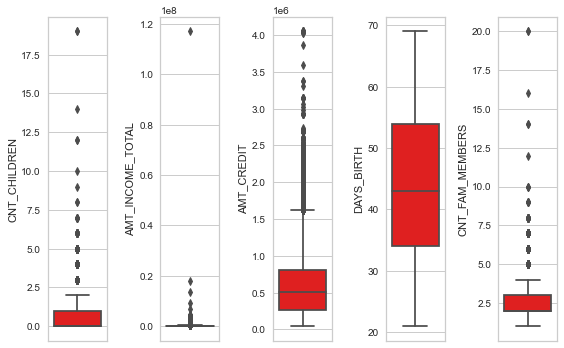

In [35]:
plt.figure(figsize=(8,5))
features = numericals_trans
for i in range(0, len(features)):
    plt.subplot(1, len(features), i+1)
    sns.boxplot(y=X_train[features[i]], color='red')
    plt.tight_layout()

In [36]:
X_train_outliers = X_train.copy()

In [37]:
outlier(X_train_outliers,'CNT_CHILDREN')

outlier_max = X_train_outliers['CNT_CHILDREN'].max()
X_train_outliers[X_train_outliers['CNT_CHILDREN'] == outlier_max]

 outlier lower limit : -1.5 
 outlier upper limit : 2.5


,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,DAYS_BIRTH,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,WEEKDAY_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,TARGET
265782,Cash loans,F,0,1,19,112500.0,135000.0,28.0,20.0,2,5,0,0
155368,Cash loans,F,0,1,19,112500.0,269550.0,30.0,20.0,2,1,0,0


In [38]:
outlier(X_train_outliers,'AMT_INCOME_TOTAL')

outlier_max = X_train_outliers['AMT_INCOME_TOTAL'].max()
X_train_outliers[X_train_outliers['AMT_INCOME_TOTAL'] == outlier_max]

 outlier lower limit : -22500.0 
 outlier upper limit : 337500.0


,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,DAYS_BIRTH,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,WEEKDAY_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,TARGET
12840,Cash loans,F,0,1,1,117000000.0,562491.0,35.0,3.0,2,3,0,1


In [39]:
outlier(X_train_outliers,'AMT_CREDIT')

outlier_max = X_train_outliers['AMT_CREDIT'].max()
X_train_outliers[X_train_outliers['AMT_CREDIT'] == outlier_max]

 outlier lower limit : -537975.0 
 outlier upper limit : 1616625.0


,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,DAYS_BIRTH,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,WEEKDAY_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,TARGET
14852,Cash loans,M,0,1,1,760846.5,4050000.0,35.0,3.0,1,4,0,0
287730,Cash loans,F,1,0,1,405000.0,4050000.0,31.0,3.0,2,4,0,0
288453,Cash loans,F,1,0,1,450000.0,4050000.0,46.0,3.0,2,3,0,0
110458,Cash loans,M,0,0,2,864900.0,4050000.0,41.0,4.0,2,5,0,0
17948,Cash loans,M,1,0,2,783000.0,4050000.0,42.0,4.0,2,5,1,0
133765,Cash loans,F,1,0,1,1307587.5,4050000.0,42.0,3.0,1,7,0,0
119680,Cash loans,M,1,1,1,931365.0,4050000.0,34.0,3.0,2,2,0,0


In [40]:
outlier(X_train_outliers,'CNT_FAM_MEMBERS')

outlier_max = X_train_outliers['CNT_FAM_MEMBERS'].max()
X_train_outliers[X_train_outliers['CNT_FAM_MEMBERS'] == outlier_max]

 outlier lower limit : 0.5 
 outlier upper limit : 4.5


,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,DAYS_BIRTH,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,WEEKDAY_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,TARGET
265782,Cash loans,F,0,1,19,112500.0,135000.0,28.0,20.0,2,5,0,0
155368,Cash loans,F,0,1,19,112500.0,269550.0,30.0,20.0,2,1,0,0


Obeservasi:
- Terdapat Outliers pada kolom `CNT_CHILDREN`,`AMT_INCOME_TOTAL`,`AMT_CREDIT`, dan `CNT_FAM_MEMBERS`
- Outliers pada kolom `CNT_CHILDREN` dan `CNT_FAM_MEMBERS` memiliki ID values dan nilai yang sama, dengan nilai jumlah anak sebanyak 19 orang dan jumlah anggota keluarga sebanyak 20 orang. Kedua hal tersebut masih masuk akal, maka tidak perlu menghapus outliers. Ada kemungkinan 2 transaksi ini dilakukan oleh orang yang sama
- Pada kolom `AMT_INCOME_TOTAL` terdapat outliers sebesar \$117000000, berarti ada pelanggan yang memiliki total pendapatan sebesar Rp.1.802.092.500.000 per tahun. Nilai tersebut tidak wajar karena nilai terlalu jauh dari boxplot dan hanya ada 1 data, maka perlu dihapus
- Nilai outliers pada kolom `AMT_CREDIT` adalah \$4050000, berarti ada pelanggan yang melakukan pinjaman kepada bank sebesar Rp.62.353.800.000. Nominal tersebut masih tergolong wajar, maka outlier tidak perlu dihapus


In [41]:
# Hapus outliers pada kolom `AMT_INCOME_TOTAL`
X_train = X_train.drop(12840)
y_train = y_train.drop(12840)

### 8.2 Check Distribution
Cek distribusi tiap kolom menggunakan KDE plot

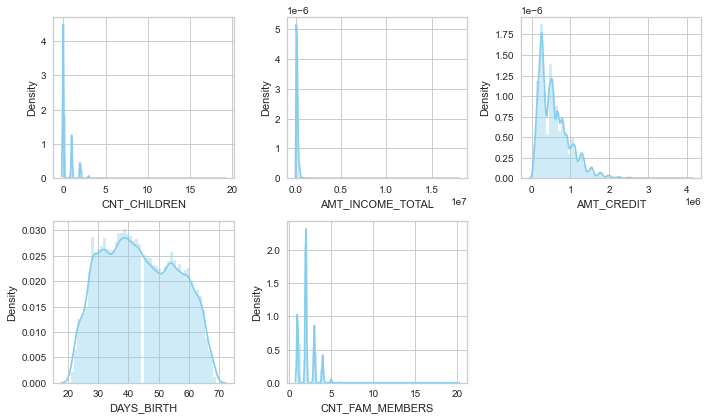

In [42]:
plt.figure(figsize=(10,6))
features = numericals_trans
for i in range(0, len(features)):
    plt.subplot(2, len(features)//2 + 1, i+1)
    #plt.subplot(1, len(features), i+1)
    sns.distplot(x=X_train[features[i]], color='skyblue')
    plt.xlabel(features[i])
    plt.tight_layout()

Observasi:
- Pada kolom `DAYS_BIRTH` bentuk grafik tidak simetris, namun tidak cukup ekstreme dan tidak positive skew. Maka dapat dicoba lakukan log tranformasi, namun jika hasilnya tidak lebih baik maka tidak perlu di transformasi
- Kolom `CNT_CHILDREN`, `AMT_INCOME_TOTAL`, `AMT_CREDIT` dan `CNT_FAM_MEMBERS` memiliki bentuk grafik yang tidak simetris dan positive skew. Maka perlu dilakukan log transformasi

## 9. Multivariate Analysis

### 9.1 Analisa Numericals Column

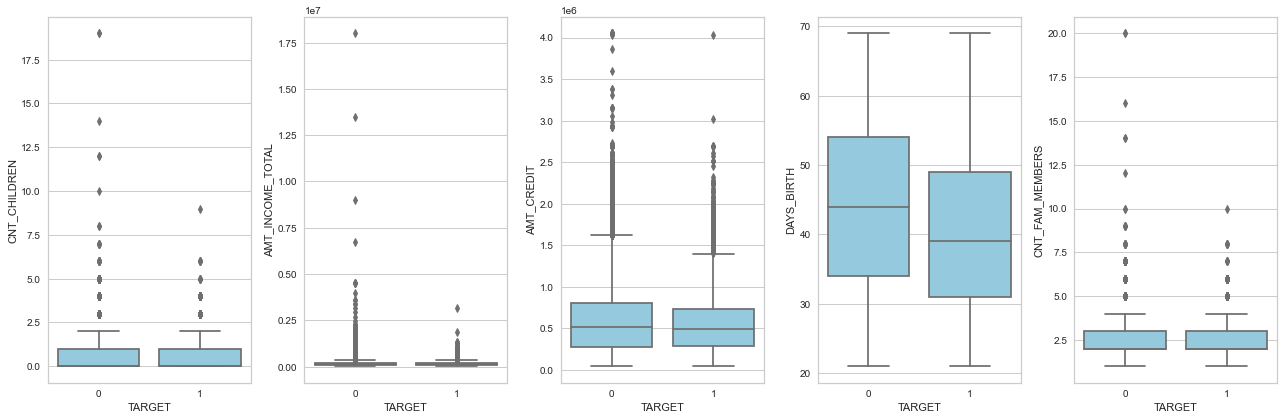

In [43]:
plt.figure(figsize=(18,6))

for x in range(0, len(numericals_trans)):
    plt.subplot(1, len(numericals_trans), x+1)
    sns.boxplot(x=X_train['TARGET'],y=X_train[numericals_trans[x]], color='skyblue')
    plt.tight_layout()

Observasi:
- Pelanggan yang memiliki jumlah anak (`CNT_CHILDREN`) >10 cenderung tidak terlambat dalam pembayaran kredit
- Pelanggan dengan pendapatan total (`AMT_INCOME_TOTAL`) >\$4000000 cenderung tidak terlambat dalam pembayaran kredit
- Pelanggan dengan total pinjaman (`AMT_CREDIT`) > \$3000000 cenderung tidak terlambat dalam pembayaran kredit
- Pelanggan yang memiliki jumlah anggota keluarga (`CNT_FAM_MEMBERS`) >10 cenderung tidak terlambat dalam pembayaran kredit

### 9.2 Analisa Customer Demographic (Categorical)

In [127]:
def predictor_target (p,t='TARGET') :
    
    ax = ((X_train.groupby([p])[t].mean())/((X_train.groupby([p])[t].mean()).sum())*100).sort_values(ascending=False).plot(kind='bar',figsize=(10,8), color='#90a955')
    abs_values = round(((X_train.groupby([p])[t].mean())/((X_train.groupby([p])[t].mean()).sum())*100),1).sort_values(ascending=False)
    ax.bar_label(container=ax.containers[0], labels=abs_values)  
    
    plt.xticks(rotation=0);
    plt.ylabel('Late Payment / TARGET (%)',fontsize=12)
    plt.title(f'{p} vs Late Payment / TARGET (%)',fontsize=16)
    plt.xlabel(p,fontsize=12)
    plt.ylim(0,100)
    
    plt.show()

In [118]:
demographic  = ['CODE_GENDER', 'REGION_RATING_CLIENT']

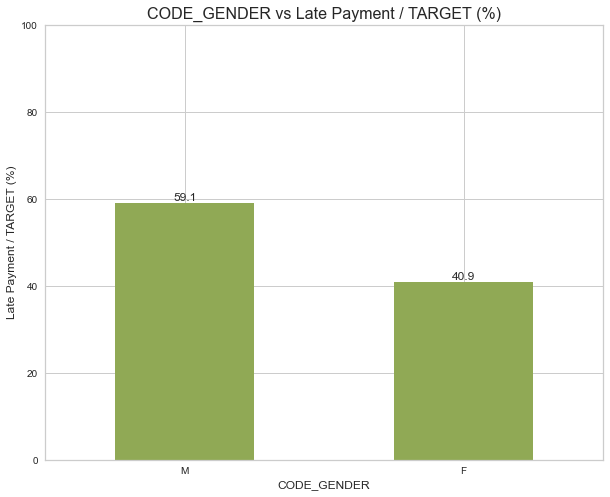

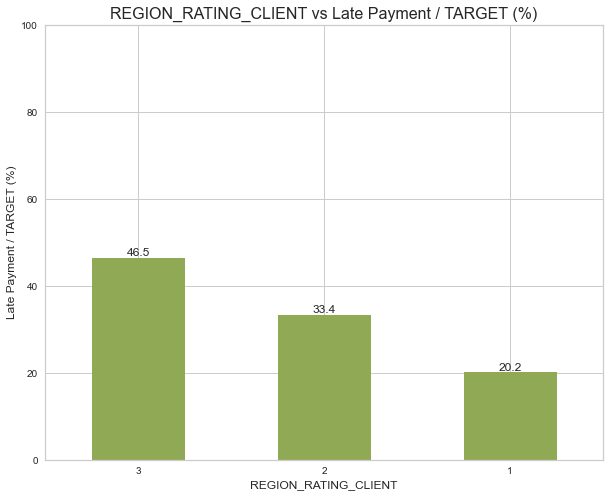

In [128]:
for x in demographic :
    predictor_target(x)

In [47]:
for x in demographic :
    chi_cek(x,'TARGET')

===== CODE_GENDER =====
Number Expected :
[[139652.16234006  12263.83765994]
 [ 72356.83765994   6354.16234006]]

Chi-square Statistic : 678.1578847140188 ,p-value: 1.6808269355791464e-149 kurang dari 0.05 
Variabel 1 dan Variabel 2 adalah variabel dependent

===== REGION_RATING_CLIENT =====
Number Expected :
[[ 22246.388324     1953.611676  ]
 [156367.28956714  13731.71043286]
 [ 33395.32210886   2932.67789114]]

Chi-square Statistic : 783.394428601661 ,p-value: 7.727895705478558e-171 kurang dari 0.05 
Variabel 1 dan Variabel 2 adalah variabel dependent



Obesrvasi:
- Feature `CODE_GENDER ` dan `REGION_RATING_CLIENT ` berkorelasi terhadap target variabel (`TARGET`)
- Pelanggan laki-laki lebih sering terlambat dalam pembayaran kredit
- Pelanggan yang tinggal dalam wilayah peringkat 3, lebih sering terlambat dalam pembayaran kredit

### 9.3 Analisa Customer Contract (Categorical)

In [125]:
contract = ['NAME_CONTRACT_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION']

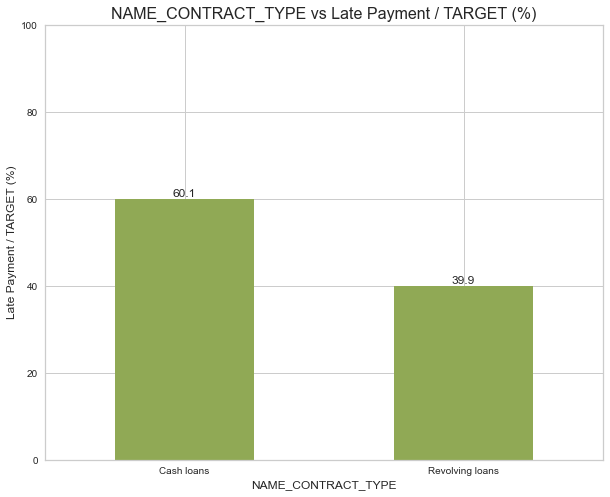

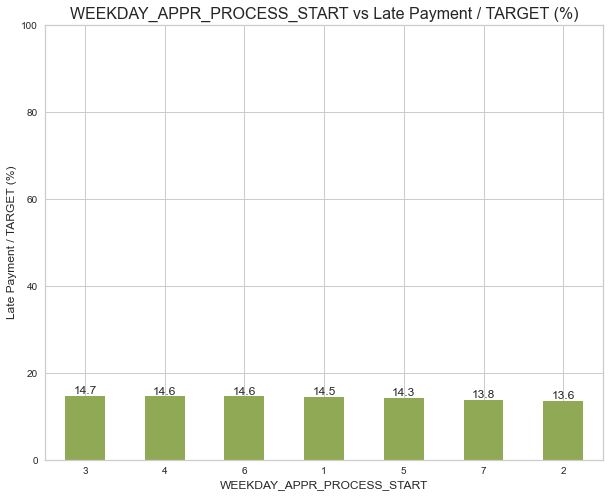

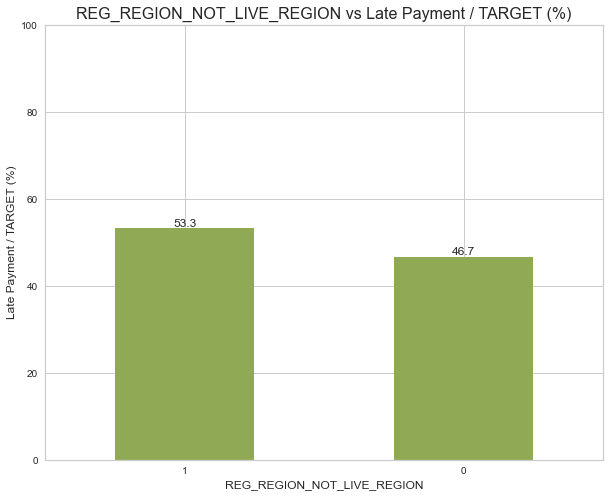

In [129]:
for x in contract :
    predictor_target(x)

In [50]:
for x in contract :
    chi_cek(x,'TARGET')

===== NAME_CONTRACT_TYPE =====
Number Expected :
[[191822.70077658  16845.29922342]
 [ 20186.29922342   1772.70077658]]

Chi-square Statistic : 208.3094505588519 ,p-value: 3.211461480492971e-47 kurang dari 0.05 
Variabel 1 dan Variabel 2 adalah variabel dependent

===== WEEKDAY_APPR_PROCESS_START =====
Number Expected :
[[11185.70467465   982.29532535]
 [35038.06161031  3076.93838969]
 [37104.5856166   3258.4143834 ]
 [35732.11215512  3137.88784488]
 [34683.22252382  3045.77747618]
 [34809.16282135  3056.83717865]
 [23456.15059815  2059.84940185]]

Chi-square Statistic : 16.4269406974669 ,p-value: 0.011636914027019904 kurang dari 0.05 
Variabel 1 dan Variabel 2 adalah variabel dependent

===== REG_REGION_NOT_LIVE_REGION =====
Number Expected :
[[208813.6096771  18337.3903229]
 [  3195.3903229    280.6096771]]

Chi-square Statistic : 5.650739900727603 ,p-value: 0.01744800868776273 kurang dari 0.05 
Variabel 1 dan Variabel 2 adalah variabel dependent



Observasi:
- Feature `NAME_CONTRACT_TYPE` dan `REG_REGION_NOT_LIVE_REGION` berkorelasi terhadap target variabel (`TARGET`)
- Feature `WEEKDAY_APPR_PROCESS_START` berkorelasi terhadap target variabel (`TARGET`), namun selisih TARGET(%) tidak terlalu jauh. Hanya berbeda 1.1% dari hari tertinggi dan terendah 
- Pelanggan yang memilih tipe kontrak Pinjaman Tunai (Cash) lebih sering terlambat dalam pembayaran kredit
- Pelanggan dengan meiliki alamat berbeda dalam pengisian form alamat tetap dan alamat kontak lebih sering terlambat dalam pembayaran kredit 

### 9.4 Analisa Customer Property (Categorical)

In [51]:
property = ['FLAG_OWN_CAR', 'FLAG_OWN_REALTY']

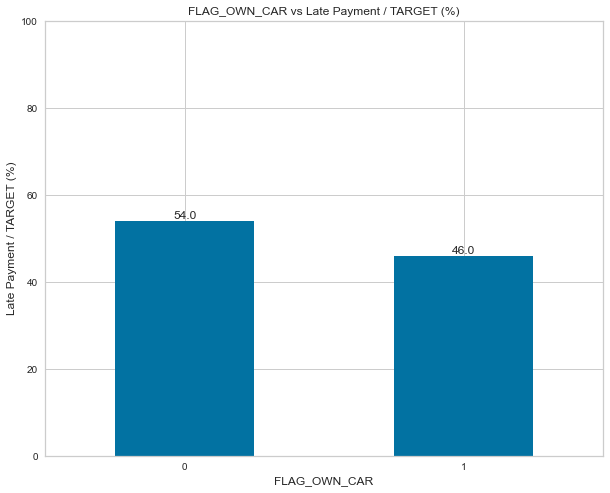

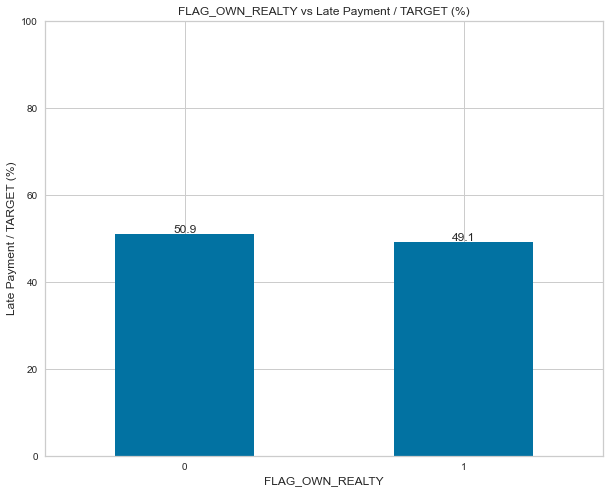

In [52]:
for x in property :
    predictor_target(x)

In [53]:
for x in property :
    chi_cek(x,'TARGET')

===== FLAG_OWN_CAR =====
Number Expected :
[[140047.44940532  12298.55059468]
 [ 71961.55059468   6319.44940532]]

Chi-square Statistic : 109.40518279344826 ,p-value: 1.3228323052680612e-25 kurang dari 0.05 
Variabel 1 dan Variabel 2 adalah variabel dependent

===== FLAG_OWN_REALTY =====
Number Expected :
[[ 64936.47209997   5702.52790003]
 [147072.52790003  12915.47209997]]

Chi-square Statistic : 5.779363801890717 ,p-value: 0.016215409657717915 kurang dari 0.05 
Variabel 1 dan Variabel 2 adalah variabel dependent



Obesrvasi:
- Feature `FLAG_OWN_CAR` berkorelasi terhadap target variabel (`TARGET`)
- Feature `FLAG_OWN_REALTY` berkorelasi terhadap target variabel (`TARGET`), namun selisih TARGET(%) tidak terlalu jauh. Hanya berbeda 1.8% antar nilai
- Pelanggan yang tidak memiliki mobil lebih sering terlambat dalam pembayaran kredit

# Data Preprocessing

In [54]:
info_data(X_train)

Number of Rows,Columns (230627, 13)
Number of Duplicated Values 1802


,Missing_value,Percent_missing_%,Data_type,Number of Unique
NAME_CONTRACT_TYPE,0,0.0,object,2
CODE_GENDER,0,0.0,object,2
FLAG_OWN_CAR,0,0.0,int64,2
FLAG_OWN_REALTY,0,0.0,int64,2
CNT_CHILDREN,0,0.0,int64,14
AMT_INCOME_TOTAL,0,0.0,float64,2059
AMT_CREDIT,0,0.0,float64,5170
DAYS_BIRTH,0,0.0,float64,49
CNT_FAM_MEMBERS,0,0.0,float64,14
REGION_RATING_CLIENT,0,0.0,int64,3


Observasi : 

Berdasarkan EDA diketahui bahwa feature `WEEKDAY_APPR_PROCESS_START` dan `FLAG_OWN_REALTY` berkorelasi terhadapa target variabel (`TARGET`) namun memiliki selisih `TARGET(%)` yang sangat kecil. Maka dapat didrop 

In [55]:
X_train_drop = X_train.copy()

In [56]:
X_train_drop = X_train.drop(['WEEKDAY_APPR_PROCESS_START','FLAG_OWN_REALTY'],axis=1)

In [57]:
info_data(X_train_drop)

Number of Rows,Columns (230627, 11)
Number of Duplicated Values 13337


,Missing_value,Percent_missing_%,Data_type,Number of Unique
NAME_CONTRACT_TYPE,0,0.0,object,2
CODE_GENDER,0,0.0,object,2
FLAG_OWN_CAR,0,0.0,int64,2
CNT_CHILDREN,0,0.0,int64,14
AMT_INCOME_TOTAL,0,0.0,float64,2059
AMT_CREDIT,0,0.0,float64,5170
DAYS_BIRTH,0,0.0,float64,49
CNT_FAM_MEMBERS,0,0.0,float64,14
REGION_RATING_CLIENT,0,0.0,int64,3
REG_REGION_NOT_LIVE_REGION,0,0.0,int64,2


## 11. Transform Object to Numeric - Training Data

### 11.1 One Hot Encoding

Feature yang akan ditransform:
1. NAME_CONTRACT_TYPE
2. CODE_GENDER	

In [58]:
X_train_drop= pd.get_dummies(X_train_drop,columns=['NAME_CONTRACT_TYPE'])
X_train_drop= pd.get_dummies(X_train_drop,columns=['CODE_GENDER'])

In [59]:
X_train_drop.head()

,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,DAYS_BIRTH,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REG_REGION_NOT_LIVE_REGION,TARGET,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_F,CODE_GENDER_M
115415,0,0,90000.0,161730.0,54.0,2.0,2,0,0,1,0,1,0
260031,0,1,112500.0,521280.0,28.0,3.0,3,0,1,1,0,1,0
128753,1,1,103500.0,315000.0,31.0,3.0,2,0,0,0,1,1,0
12997,0,0,135000.0,536917.5,62.0,2.0,2,0,0,1,0,1,0
166440,0,0,81000.0,350860.5,65.0,1.0,2,0,0,1,0,1,0


## 12. Feature Selection

In [60]:
X_train_drop = X_train_drop.drop('TARGET',axis=1)

In [61]:
mi = mutual_info_classif(X_train_drop, y_train,random_state=42)

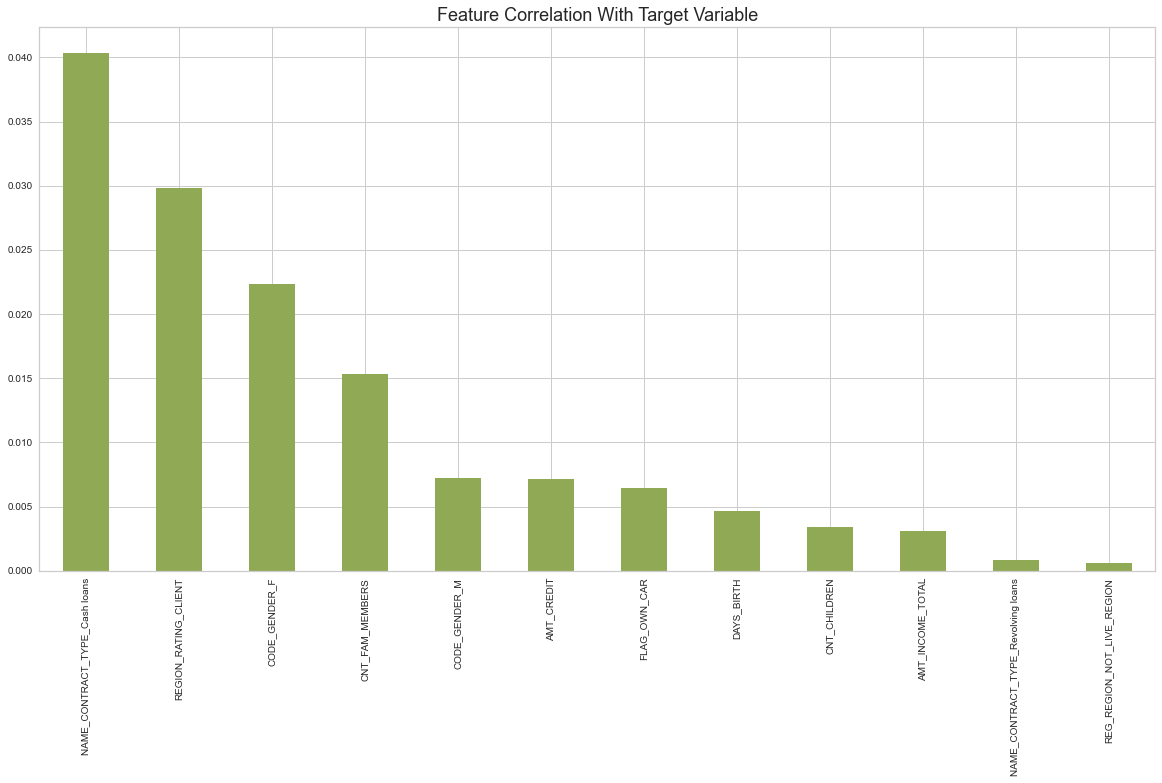

In [124]:
mi = pd.Series(mi)
mi.index = X_train_drop.columns
mi.sort_values(ascending=False).plot(kind='bar', figsize=(20,10), color='#90a955')
plt.title('Feature Correlation With Target Variable',fontsize=18)
plt.show()

In [63]:
# Select top 10 features
X_train_top10 = X_train_drop.drop(['NAME_CONTRACT_TYPE_Revolving loans','REG_REGION_NOT_LIVE_REGION'],axis=1)
X_train_top10.head()

,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,DAYS_BIRTH,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,NAME_CONTRACT_TYPE_Cash loans,CODE_GENDER_F,CODE_GENDER_M
115415,0,0,90000.0,161730.0,54.0,2.0,2,1,1,0
260031,0,1,112500.0,521280.0,28.0,3.0,3,1,1,0
128753,1,1,103500.0,315000.0,31.0,3.0,2,0,1,0
12997,0,0,135000.0,536917.5,62.0,2.0,2,1,1,0
166440,0,0,81000.0,350860.5,65.0,1.0,2,1,1,0


## 13. Transform Object to Numeric - Testing Data

In [64]:
### Encoding yes or no
for colname in ['FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
    X_test[colname] = X_test[colname].map(yes_no_dict)

In [65]:
## One Hot Encoding
X_test = pd.get_dummies(X_test,columns=['NAME_CONTRACT_TYPE'])
X_test = pd.get_dummies(X_test,columns=['CODE_GENDER'])

In [66]:
X_test_top10 = X_test.copy()
X_test_top10 = X_test_top10[X_train_top10.columns]
X_test_top10.head()

,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,DAYS_BIRTH,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,NAME_CONTRACT_TYPE_Cash loans,CODE_GENDER_F,CODE_GENDER_M
229269,0,1,157500.0,592560.0,34.0,2.0,2,1,0,1
142049,1,0,211500.0,1100709.0,47.0,2.0,2,1,0,1
119753,1,2,126000.0,270000.0,40.0,4.0,2,0,1,0
259016,0,0,225000.0,343800.0,25.0,1.0,2,1,1,0
54373,0,0,112500.0,497520.0,50.0,2.0,2,1,0,1


## 14. Feature Transformation

In [67]:
# Select feature yang akan di log transform
feature_t = ['CNT_CHILDREN','AMT_INCOME_TOTAL','AMT_CREDIT','CNT_FAM_MEMBERS']

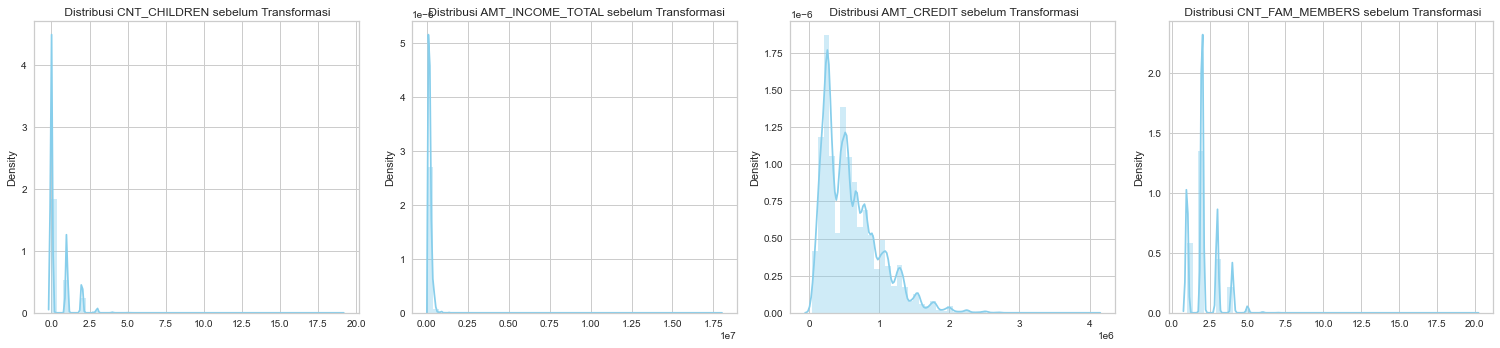

In [68]:
plt.figure(figsize=(21,5))

for x in range(0, len(feature_t)):
    plt.subplot(1, len(feature_t), x+1)
    sns.distplot(x=X_train_top10[feature_t[x]], color='skyblue')
    plt.title(f' Distribusi {feature_t[x]} sebelum Transformasi')
    plt.tight_layout()

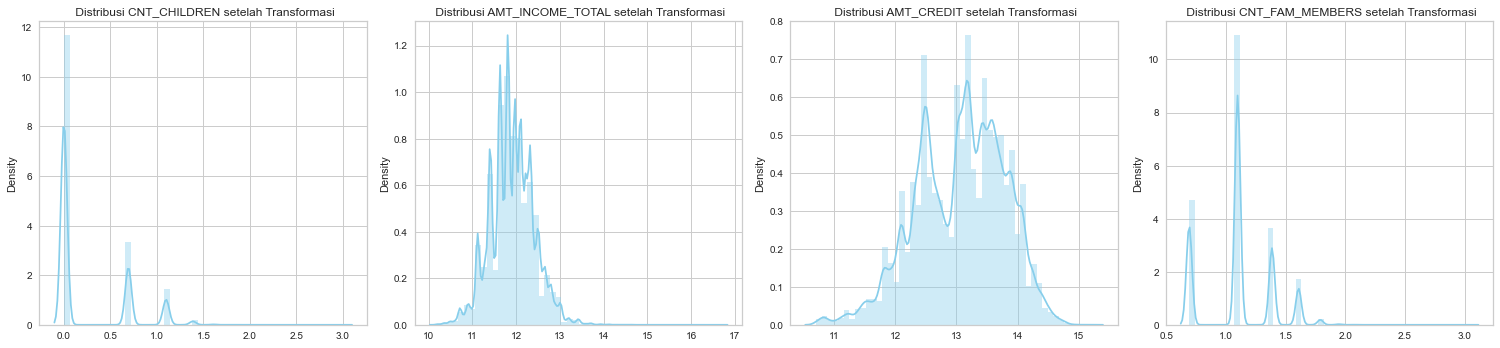

In [69]:
plt.figure(figsize=(21,5))

for x in range(0, len(feature_t)):
    plt.subplot(1, len(feature_t), x+1)
    sns.distplot(x=np.log1p(X_train_top10[feature_t[x]]), color='skyblue')
    plt.title(f' Distribusi {feature_t[x]} setelah Transformasi')
    plt.tight_layout()

## 15. Feature Scalling

In [70]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

#### Data Training

In [71]:
X_train_top10.head()

,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,DAYS_BIRTH,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,NAME_CONTRACT_TYPE_Cash loans,CODE_GENDER_F,CODE_GENDER_M
115415,0,0,90000.0,161730.0,54.0,2.0,2,1,1,0
260031,0,1,112500.0,521280.0,28.0,3.0,3,1,1,0
128753,1,1,103500.0,315000.0,31.0,3.0,2,0,1,0
12997,0,0,135000.0,536917.5,62.0,2.0,2,1,1,0
166440,0,0,81000.0,350860.5,65.0,1.0,2,1,1,0


In [72]:
feature_s = ['FLAG_OWN_CAR','CNT_CHILDREN','AMT_INCOME_TOTAL','AMT_CREDIT', 'DAYS_BIRTH','CNT_FAM_MEMBERS','REGION_RATING_CLIENT']

In [73]:
X_train_top10[feature_s] = scaler.fit_transform(X_train_top10[feature_s])

In [74]:
X_train_top10.head()

,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,DAYS_BIRTH,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,NAME_CONTRACT_TYPE_Cash loans,CODE_GENDER_F,CODE_GENDER_M
115415,-0.716824,-0.579275,-0.697269,-1.087202,0.841436,-0.168534,-0.103194,1,1,0
260031,-0.716824,0.804384,-0.497727,-0.194853,-1.332592,0.927930,1.859158,1,1,0
128753,1.395042,0.804384,-0.577544,-0.706809,-1.081743,0.927930,-0.103194,0,1,0
12997,-0.716824,-0.579275,-0.298186,-0.156043,1.510367,-0.168534,-0.103194,1,1,0
166440,-0.716824,-0.579275,-0.777085,-0.617809,1.761217,-1.264998,-0.103194,1,1,0


#### Data Testing

In [75]:
X_test_top10[feature_s] = scaler.fit_transform(X_test_top10[feature_s])

In [76]:
X_test_top10.head()

,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,DAYS_BIRTH,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,NAME_CONTRACT_TYPE_Cash loans,CODE_GENDER_F,CODE_GENDER_M
229269,-0.721193,0.816020,-0.107273,-0.010419,-0.830224,-0.164895,-0.102655,1,0,1
142049,1.386591,-0.572312,0.455235,1.256193,0.255098,-0.164895,-0.102655,1,0,1
119753,1.386591,2.204352,-0.435403,-0.814432,-0.329306,2.041083,-0.102655,0,1,0
259016,-0.721193,-0.572312,0.595862,-0.630479,-1.581601,-1.267884,-0.102655,1,1,0
54373,-0.721193,-0.572312,-0.576029,-0.247316,0.505557,-0.164895,-0.102655,1,0,1


## 16. Over Sampling

In [77]:
from imblearn.over_sampling import SMOTE

In [78]:
smote = SMOTE(0.5,random_state=42)

In [79]:
pd.Series(y_train).value_counts()

0    212009
1     18618
Name: TARGET, dtype: int64

In [80]:
X_train_smote,y_train_smote = smote.fit_resample(X_train_top10,y_train)

In [81]:
pd.Series(y_train_smote).value_counts()

0    212009
1    106004
Name: TARGET, dtype: int64

# Model,Evaluation, Feature Importance

## 17. Model

### 17.1 Logistic Regression

In [82]:
logreg_model = LogisticRegression(random_state=42,class_weight='balance')

 Recall Score : 0.0
 Precision Score : 0.0
 F1 Score : 0.0
 ROC-AUC Score : 0.631553698692668


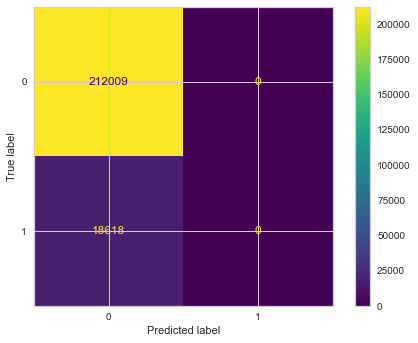

In [83]:
eval_train(X_train_top10,y_train,logreg_model)

 Recall Score : 0.0
 Precision Score : 0.0
 F1 Score : 0.0
 ROC-AUC Score : 0.6291049623841237


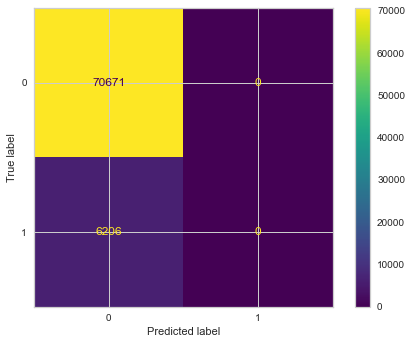

In [84]:
eval_test(X_test_top10,y_test,logreg_model)

### Over Sampling SMOTE

 Recall Score : 0.1160710916569186
 Precision Score : 0.54123960761888
 F1 Score : 0.19114939760907898
 ROC-AUC Score : 0.6338567095670399


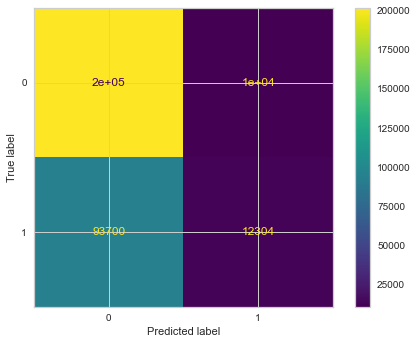

In [85]:
eval_train(X_train_smote,y_train_smote,logreg_model)

 Recall Score : 0.11263293586851435
 Precision Score : 0.16579696394686907
 F1 Score : 0.13413932066781808
 ROC-AUC Score : 0.6285540077768323


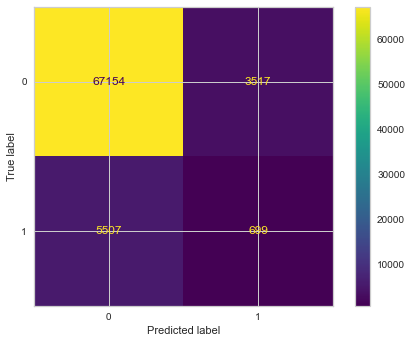

In [86]:
eval_test(X_test_top10,y_test,logreg_model)

### 17.2 KNN

In [87]:
knn_model = KNeighborsClassifier()

 Recall Score : 0.06284241057041573
 Precision Score : 0.6236673773987207
 F1 Score : 0.11417975992973553
 ROC-AUC Score : 0.8899987101739961


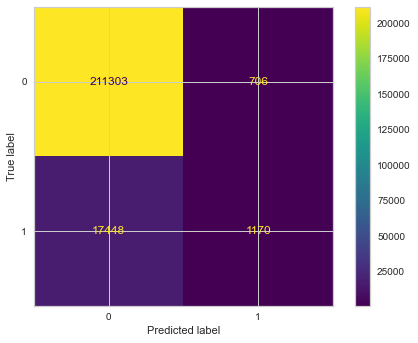

In [88]:
eval_train(X_train_top10,y_train,knn_model)

 Recall Score : 0.015630035449564938
 Precision Score : 0.15746753246753248
 F1 Score : 0.02843740838463794
 ROC-AUC Score : 0.5422150955333264


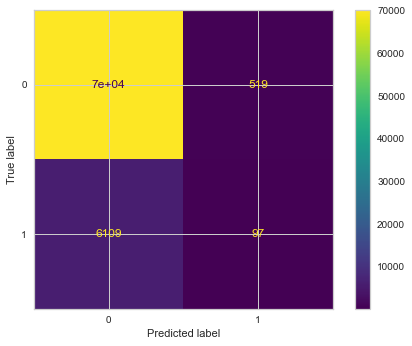

In [101]:
eval_test(X_test_top10,y_test,knn_model)

### 17.3 Naive Bayes

In [90]:
naive = GaussianNB()

 Recall Score : 0.0045117628101836935
 Precision Score : 0.15412844036697249
 F1 Score : 0.008766894536346083
 ROC-AUC Score : 0.6173819328952707


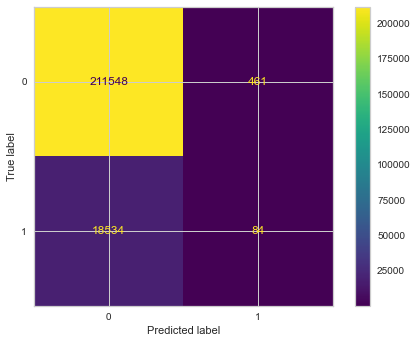

In [91]:
eval_train(X_train_top10,y_train,naive)

 Recall Score : 0.00338382210763777
 Precision Score : 0.1320754716981132
 F1 Score : 0.006598586017282011
 ROC-AUC Score : 0.6168982078256503


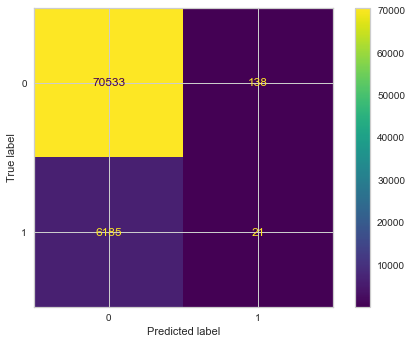

In [92]:
eval_test(X_test_top10,y_test,naive)

### Over Sampling Naive Bayes

 Recall Score : 0.41191841817289915
 Precision Score : 0.4537094763092269
 F1 Score : 0.4318051462589743
 ROC-AUC Score : 0.6229053760274031


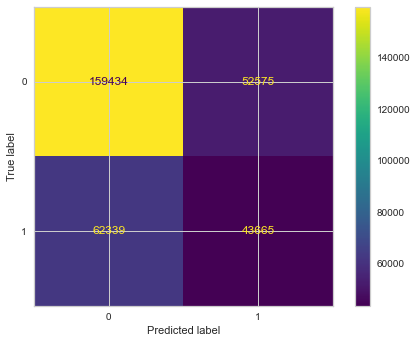

In [93]:
eval_train(X_train_smote,y_train_smote,naive)

 Recall Score : 0.3881727360618756
 Precision Score : 0.1261983341191262
 F1 Score : 0.19047242538050996
 ROC-AUC Score : 0.6156715266818555


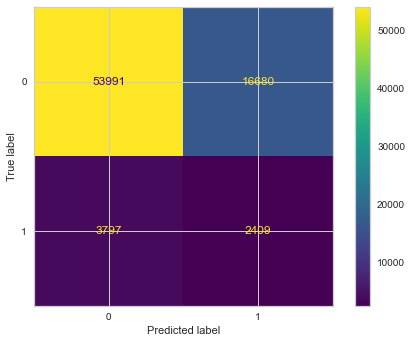

In [94]:
eval_test(X_test_top10,y_test,naive)

### 17.4 Decision Tree

In [95]:
dt = DecisionTreeClassifier(random_state=42)

 Recall Score : 0.9043398861317005
 Precision Score : 0.998103029225206
 F1 Score : 0.9489108687688449
 ROC-AUC Score : 0.9995353910019146


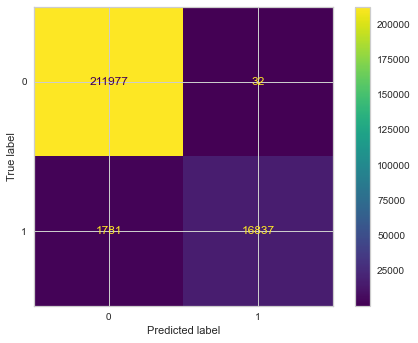

In [116]:
eval_train(X_train_top10,y_train,dt)

 Recall Score : 0.1308411214953271
 Precision Score : 0.1025123090518874
 F1 Score : 0.11495717420542224
 ROC-AUC Score : 0.5150865024498167


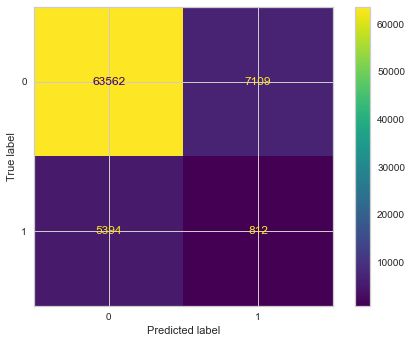

In [97]:
eval_test(X_test_top10,y_test,dt)

Konklusi : 

Dari beberapa model yang diuji, model yang dipilih adalah Naive Bayes dengan Over Sampling, karna memiliki f-1 score yang relatif tinggi dibandingkan yang lain yaitu 61%. Selain itu, model juga memiliki ROC-AUC Score yang tinggi yaitu 83%, maka model memiliki kemampuan untuk membedakan antara 0 dan 1 dengan baik.

# Recommendation

Selain model, dari analisa yang telah dilakukan terdapat beberapa insight yang dapat digunakan perusahaan dalam menentukan pinjaman pada pelanggan, antara lain :
1. Pelanggan laki-laki lebih sering terlambat dalam pembayaran kredit
2. Pelanggan yang tinggal dalam wilayah peringkat 3, lebih sering terlambat dalam pembayaran kredit
3. Pelanggan yang memilih tipe kontrak Pinjaman Tunai (Cash) lebih sering terlambat dalam pembayaran kredit